In [75]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

MEN_DIR = './man'
WOMEN_DIR = './woman'
IMG_SIZE = 100
ep = 20
LR = 1e-3

MODEL_NAME = 'menvswomen'+str(IMG_SIZE)+'-'+str(ep)+'-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [76]:
def man_data():
    label = [1,0]
    man_data = []
    for img in tqdm(os.listdir(MEN_DIR)):
        path = os.path.join(MEN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        man_data.append([np.array(img),np.array(label)])
    shuffle(man_data)
    np.save('man.npy', man_data)
    return man_data
def woman_data():
    label = [0,1]
    woman_data = []
    for img in tqdm(os.listdir(WOMEN_DIR)):
        path = os.path.join(WOMEN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        woman_data.append([np.array(img),np.array(label)])
#         print(type([np.array(img),np.array(label)]))
    shuffle(woman_data)
    np.save('woman.npy', woman_data)
    return woman_data

In [77]:
man_data = man_data()
woman_data = woman_data()

100%|██████████| 705/705 [00:00<00:00, 1726.49it/s]


In [78]:
# print(woman_data[:500])
# print(man_data[:500])

In [79]:
train_data= woman_data[:500]+man_data[:500]
test_data = woman_data[500:]+man_data[500:]

In [80]:
# print(train_data[1][0])

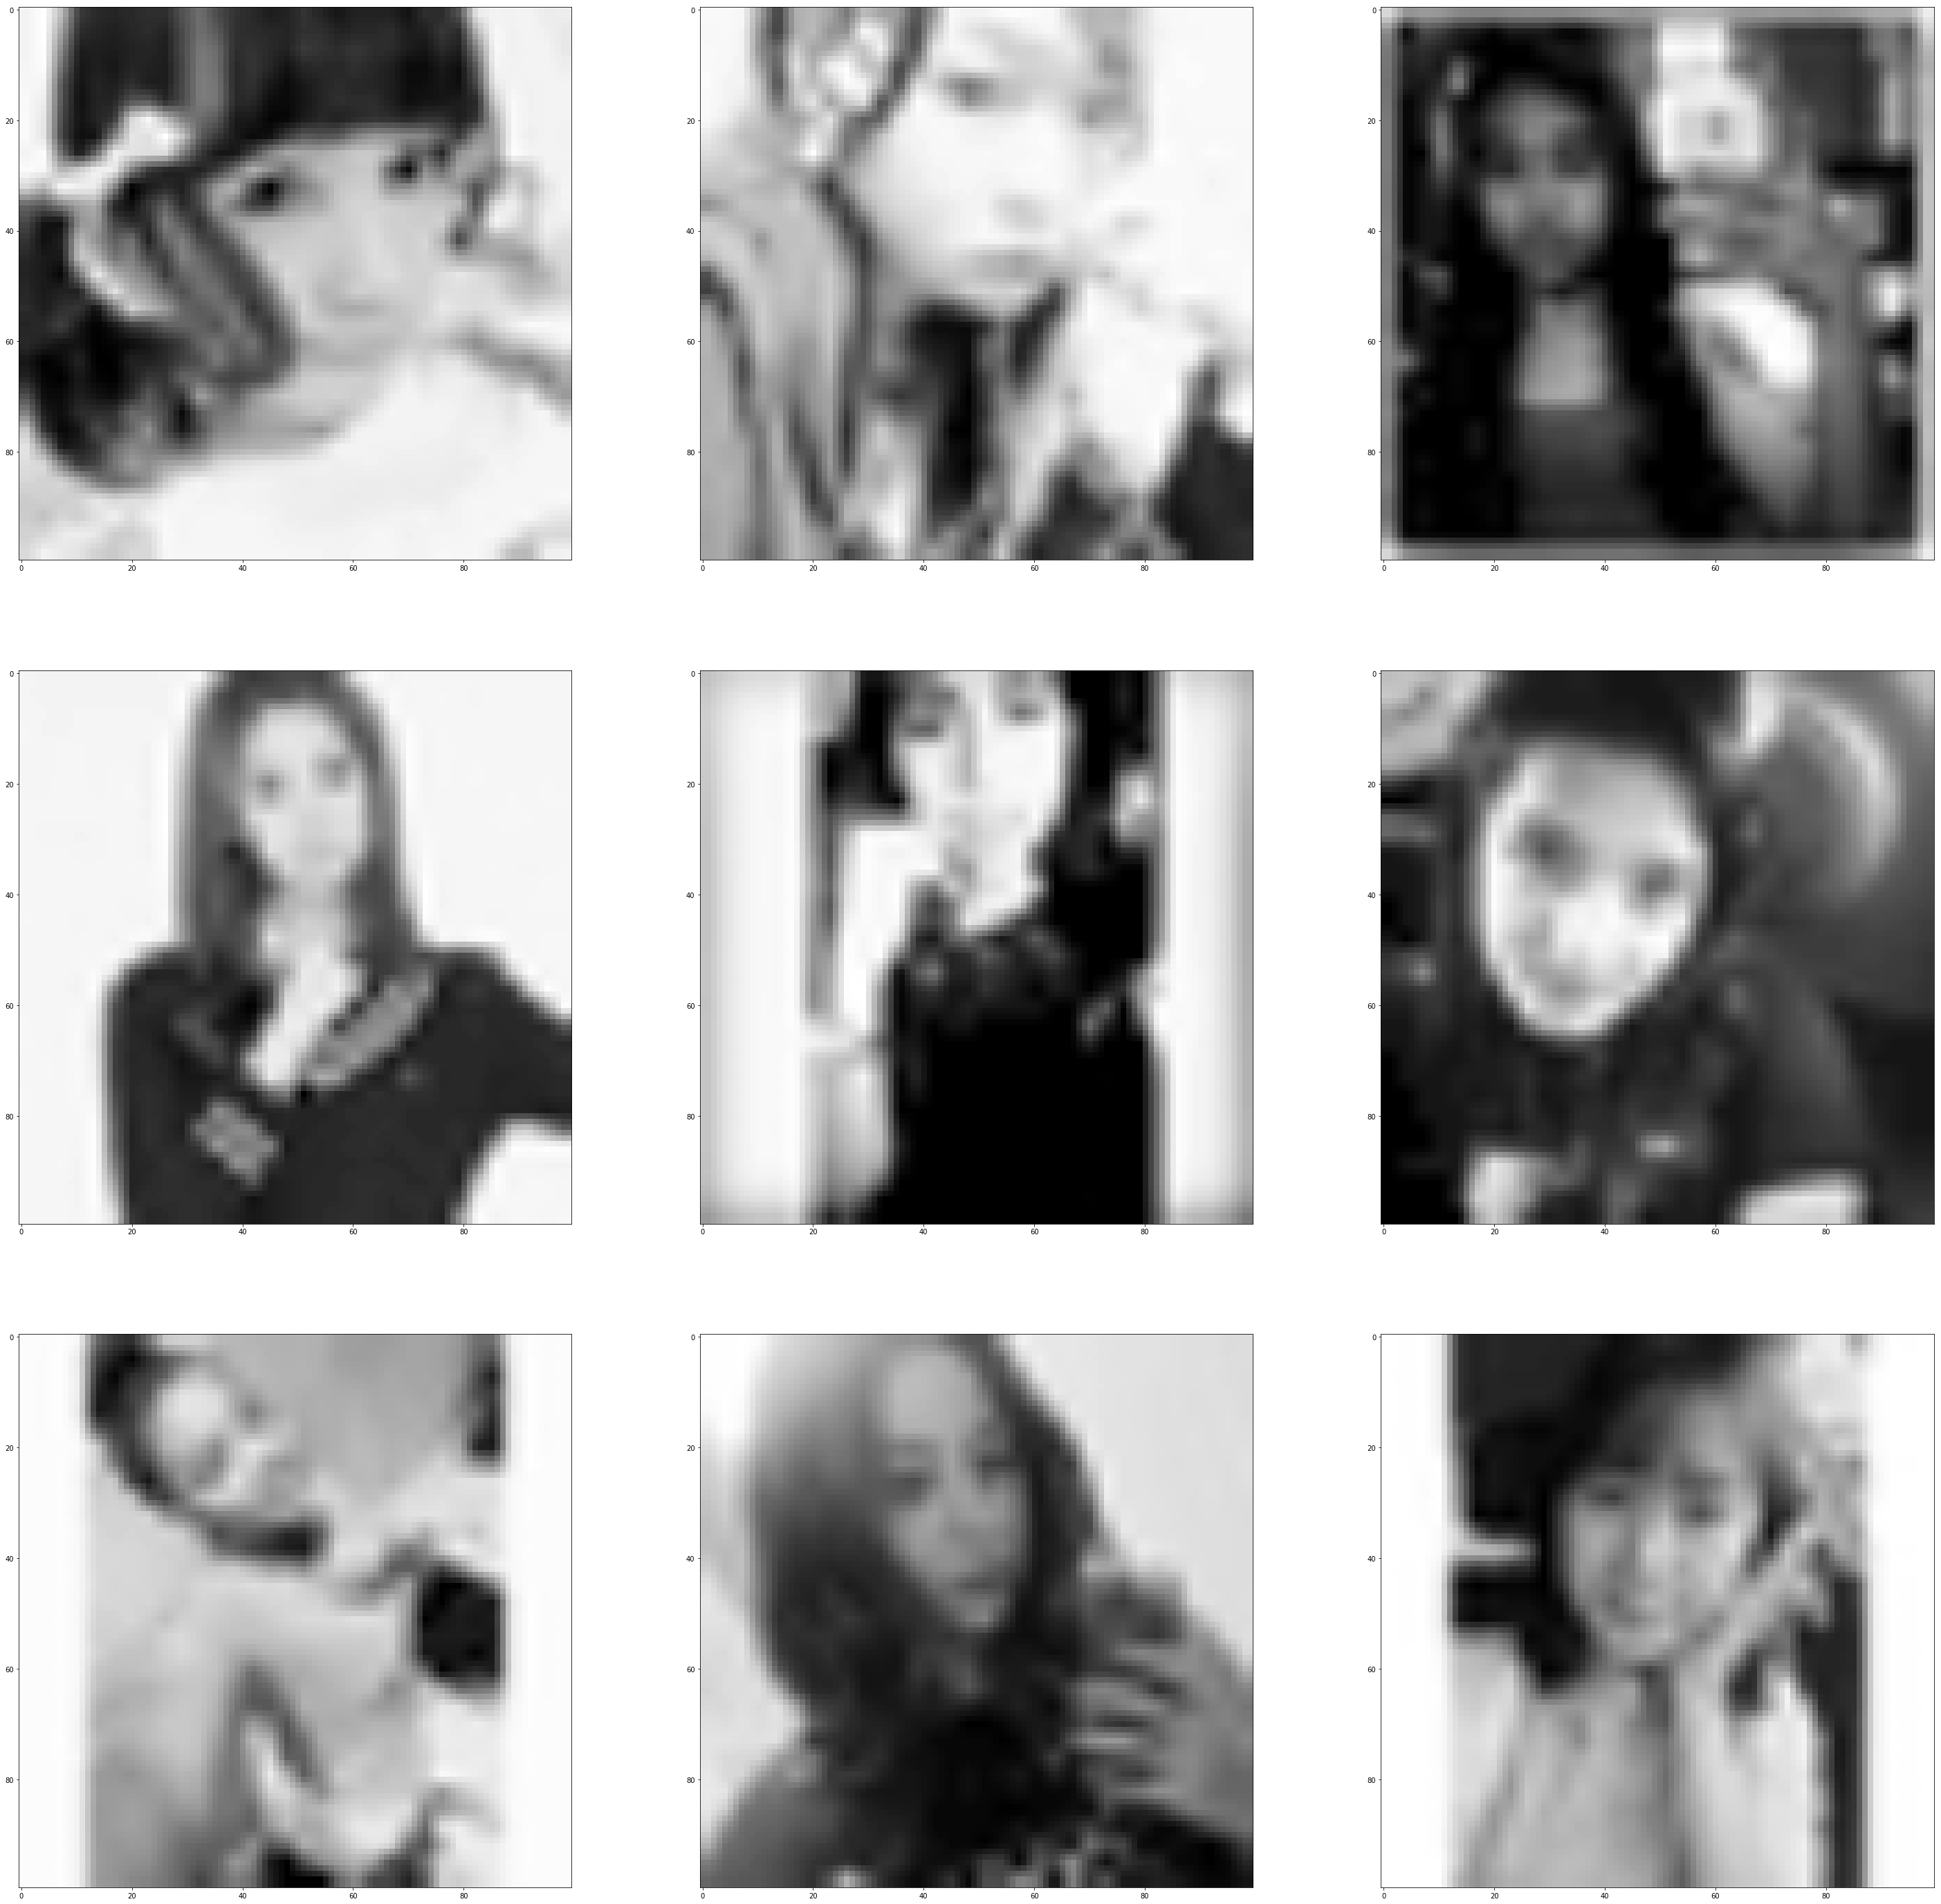

In [81]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(50, 50))  # width, height in inches

for i in range(9):
    sub = fig.add_subplot(3, 3, i + 1)
    sub.imshow(train_data[i][0], cmap = 'gray',interpolation='nearest')
plt.show()

In [82]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import keras.backend as K
K.clear_session()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [83]:
if os.path.exists('/Users/paulliu/Desktop/SIG-AI/tensorflow/cnn_practice/man_and_woman/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-50]
test = train_data[-50:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=ep, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 299  | total loss: 0.09705 | time: 5.321s
| Adam | epoch: 020 | loss: 0.09705 - acc: 0.9679 -- iter: 896/950
Training Step: 300  | total loss: 0.10291 | time: 6.695s
| Adam | epoch: 020 | loss: 0.10291 - acc: 0.9664 | val_loss: 1.45814 - val_acc: 0.6400 -- iter: 950/950
--
INFO:tensorflow:/Users/paulliu/Desktop/SIG-AI/tensorflow/cnn_practice/man_and_woman/menvswomen100-20-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [84]:
test_reshaped = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
predicted = model.predict(test_reshaped)

In [85]:
# print(predicted)

woman
woman
woman
man
woman
woman
man
man
man


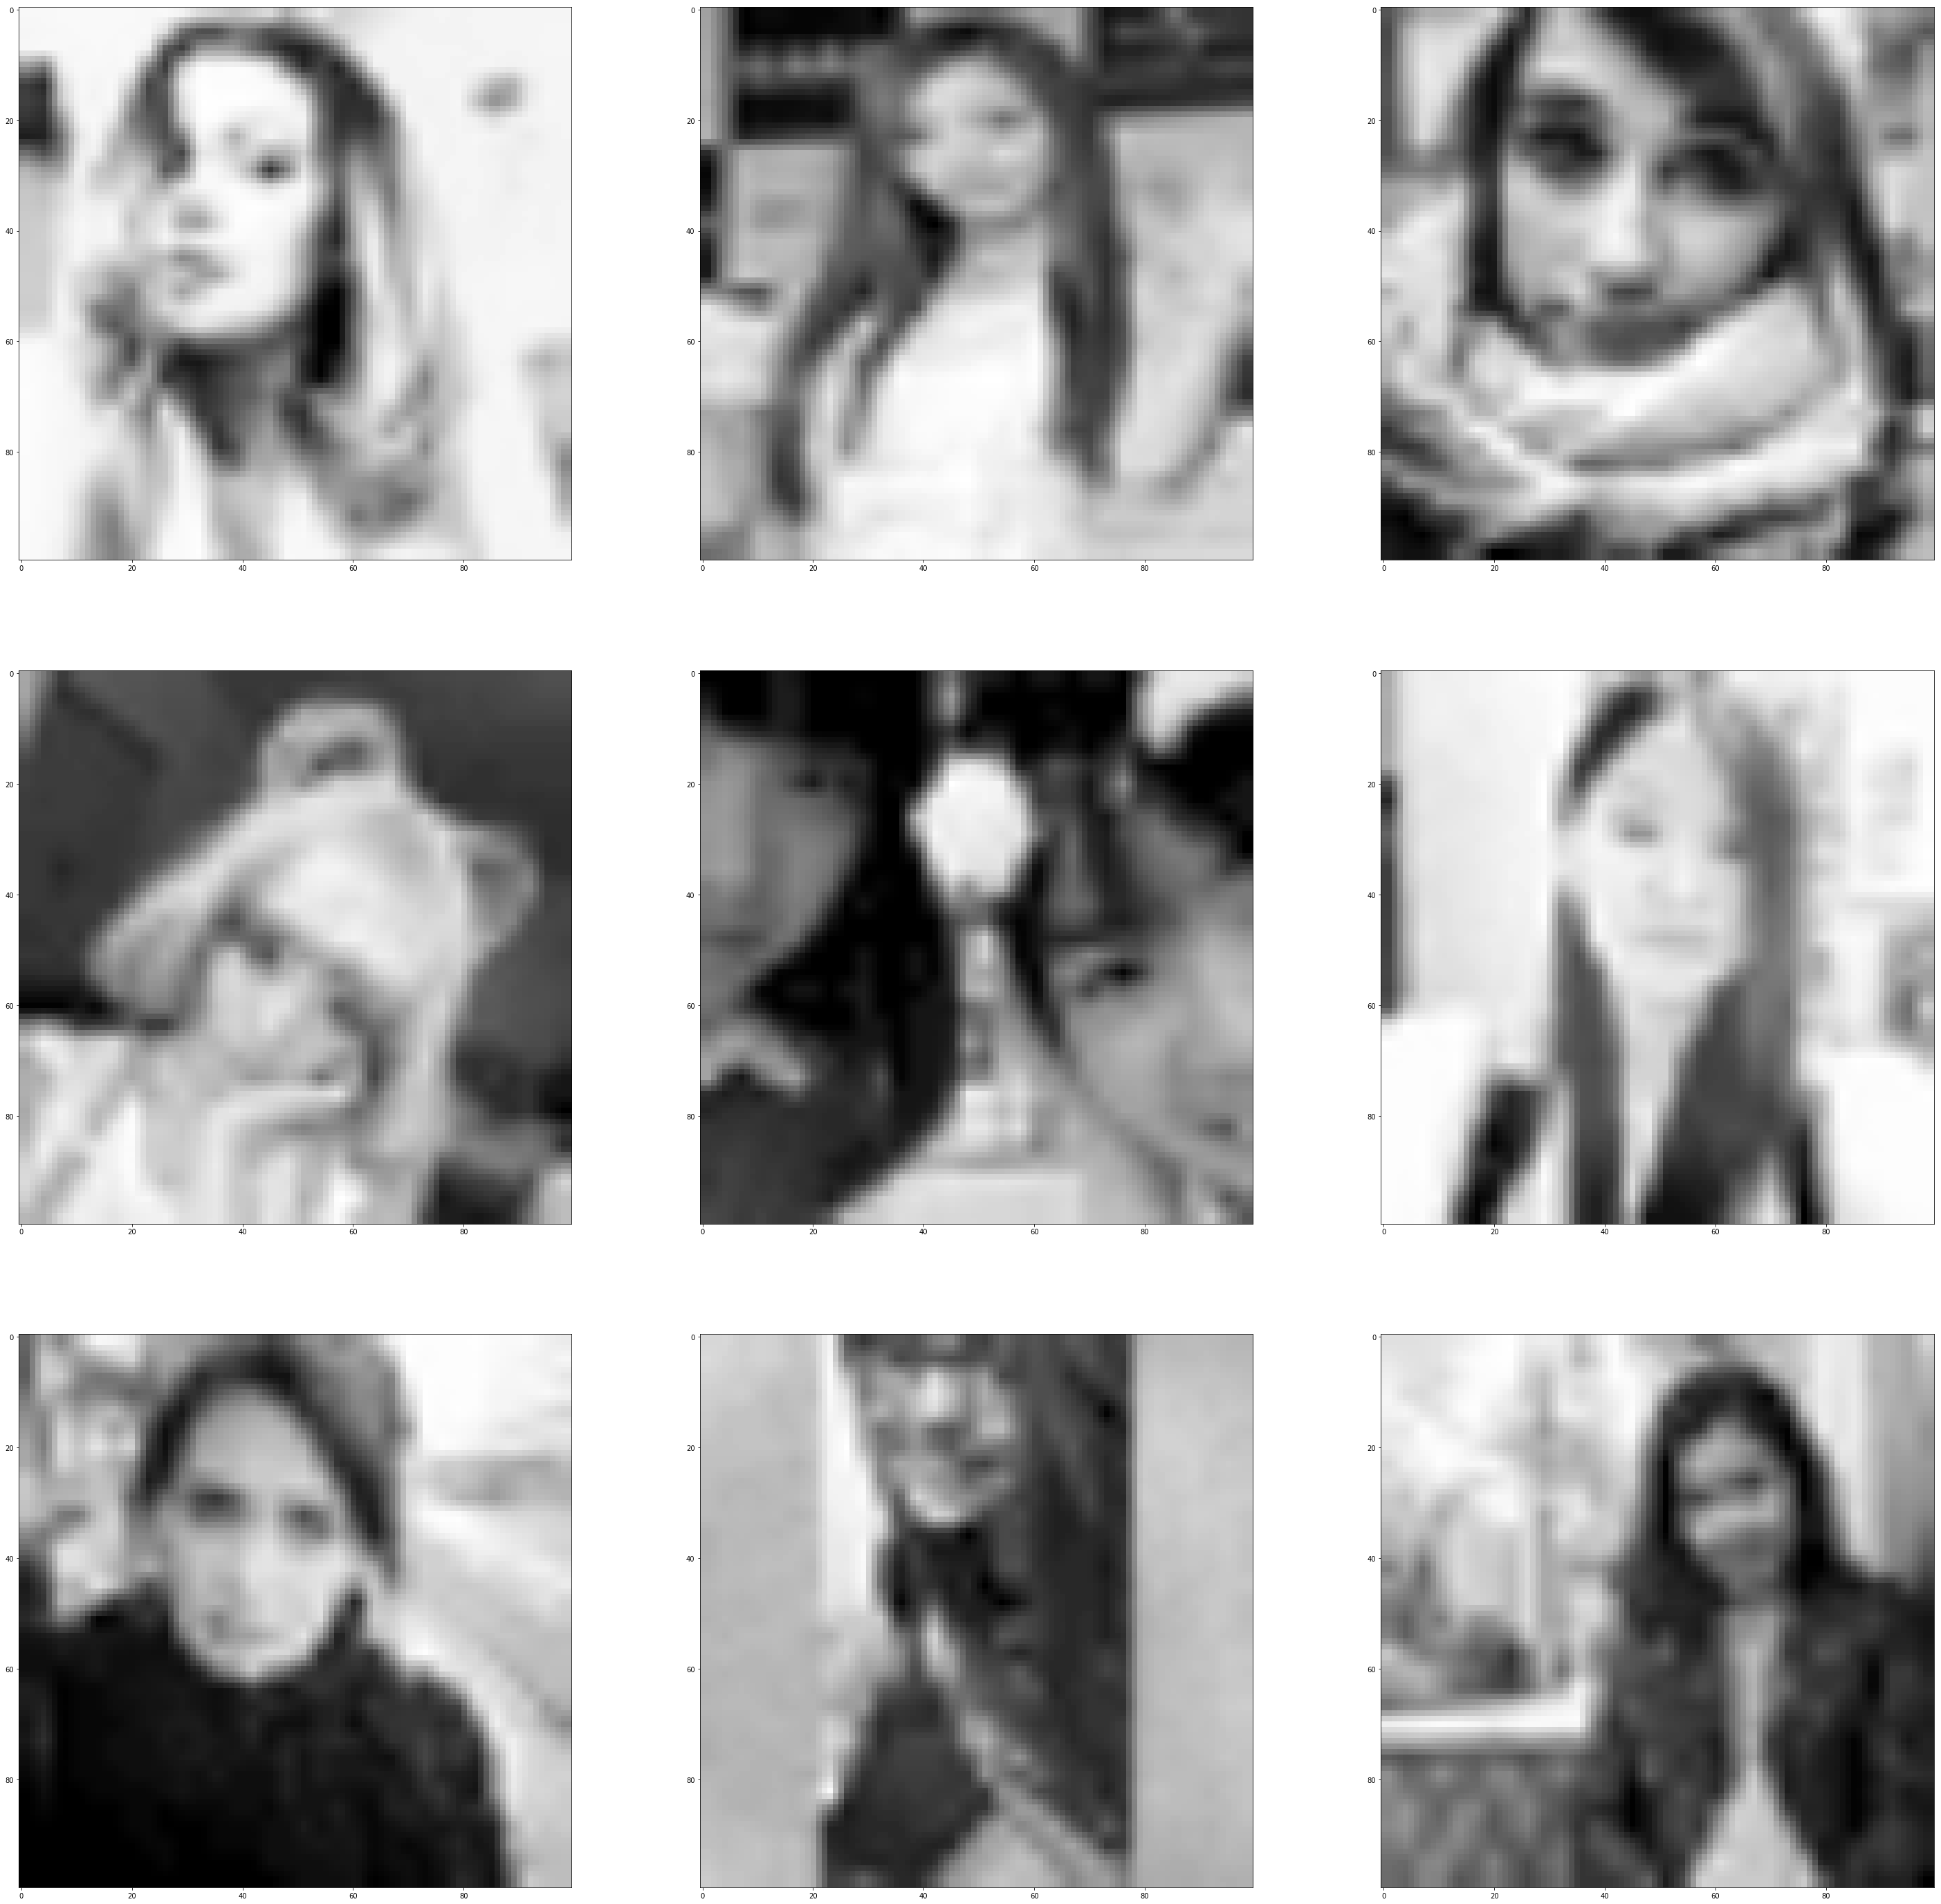

In [86]:
result = plt.figure(figsize=(50, 50))
for i in range(9):
    result_sub = result.add_subplot(3, 3, i + 1)
    result_sub.imshow(test_data[i][0], cmap = 'gray',interpolation='nearest')
    label = ''
    predicted_d = predicted[i]
    if predicted_d[0] > predicted_d[1]:
        label = 'man'
    else:
        label = 'woman'
    print(label)
plt.show()
test_labels_final = np.array([i[1] for i in test_data])
# print(test_labels_final)

In [87]:
test_labels = []
for i in range(len(test_labels_final)):
    if test_labels_final[i][0] == 0:
        test_labels.append('woman')
    else:
        test_labels.append('man')

In [89]:
predicted_labels = []
for i in range(len(predicted)):
    predicted_d = predicted[i]
    if predicted_d[0] > predicted_d[1]:
        predicted_labels.append('man')
    else:
        predicted_labels.append('woman')
# print(predicted_labels)
# print(test_labels)
rate = 0
for i in range(len(predicted_labels)):
    if predicted_labels[i] == test_labels[i]:
        rate+=1
rate /= len(predicted_labels)
print(rate)

0.7097560975609756
